In [1]:
import json

# Load the config file
with open('keys.json', 'r') as keys_file:
    keys = json.load(keys_file)

# Access the API keys
AV_API_KEY = keys['AV_KEY']
O_API_KEY = keys['OPENWEB_KEY']
base_url = keys['OPENWEB_Base_URL']

In [2]:
import requests
import fireducks.pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime, timedelta
import numpy as np
from openai import OpenAI


# Initialize the client with Open WebUI's OpenAI-compatible endpoint
client = OpenAI(
    base_url=base_url, 
    api_key=O_API_KEY
)

Enter a ticker TSLA


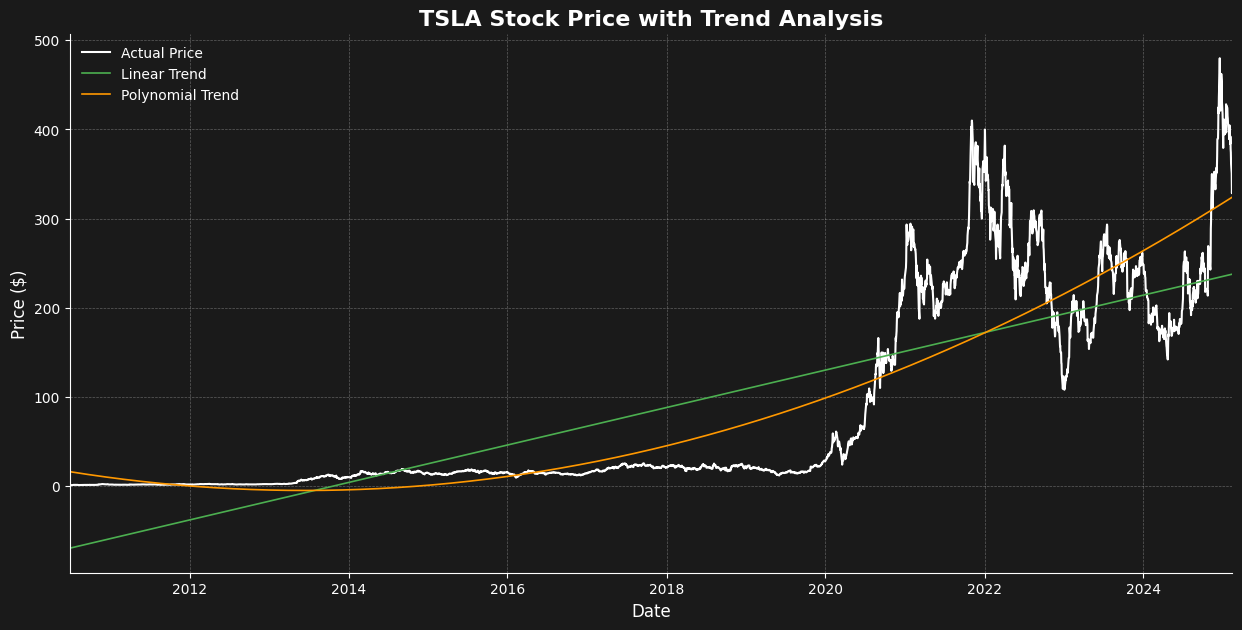

Available models for analysis are:
1. llama3.3:latest
2. llama3.2-vision:11b
3. deepseek-r1:32b
4. deepseek-r1:70b


Please enter the number of the model you want to use for analysis:  1


You've selected llama3.3:latest for analysis.
llama3.3:latest Analysis: The provided trend coefficients for the stock TSLA (Tesla, Inc.) offer insights into its price movement over a certain period. Let's analyze these trends based on the information given:

### Linear Trend Coefficient: 0.06
- **Interpretation**: A linear trend coefficient of 0.06 indicates that for every unit increase in time (assuming time is measured in a consistent interval, such as days), the stock price tends to increase by $0.06. This suggests a steady and positive linear trend.
- **Implication**: Over the period in question, Tesla's stock has shown a consistent upward movement. The linear model implies that each day (or whatever unit of time is used), on average, you could expect the stock price of TSLA to increase by $0.06.

### Polynomial Trend Coefficient: -0.04
- **Interpretation**: A polynomial trend coefficient of -0.04 may indicate a more complex or curved relationship between time and stock price. Unli

In [3]:
# Function to fetch daily stock data from Alpha Vantage
def fetch_stock_data(symbol, api_key):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full"
    r = requests.get(url)
    data = r.json()
    if 'Time Series (Daily)' not in data:
        raise ValueError("Failed to fetch data or API key is incorrect.")
    df = pd.DataFrame(data['Time Series (Daily)']).T
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. adjusted close': 'Adj Close', '6. volume': 'Volume'})
    # Ensure 'Close' is numeric
    df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')
    return df[['Adj Close']]

# Input a ticker
symbol = input('Enter a ticker')  # Example stock symbol, you can change this
df = fetch_stock_data(symbol, AV_API_KEY)

# Prepare data for trend analysis
df['Date'] = df.index
df['Day'] = (df['Date'] - df['Date'].min())  / np.timedelta64(1,'D')
X = df['Day'].values.reshape(-1, 1)
y = df['Adj Close'].values

# Linear Trend
linear_reg = LinearRegression()
linear_reg.fit(X, y)
df['Linear_Trend'] = linear_reg.predict(X)

# Polynomial Trend (Quadratic for example)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)
df['Poly_Trend'] = poly_reg.predict(X_poly)

# Plotting 
plt.figure(figsize=(15, 7))
plt.gcf().set_facecolor('#1a1a1a') 
plt.gca().set_facecolor('#1a1a1a') 

# Styling 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('white')
plt.gca().spines['bottom'].set_color('white')
plt.gca().tick_params(axis='x', colors='white', which='both')
plt.gca().tick_params(axis='y', colors='white', which='both')

# Plotting chart lines
plt.plot(df.index, df['Adj Close'], color='white', linewidth=1.5, label='Actual Price')
plt.plot(df.index, df['Linear_Trend'], color='#4CAF50', linewidth=1.2, label='Linear Trend')
plt.plot(df.index, df['Poly_Trend'], color='#FF9800', linewidth=1.2, label='Polynomial Trend')

# Adjusting title, labels for visibility and style
plt.title(f'{symbol} Stock Price with Trend Analysis', color='white', fontsize=16, fontweight='bold')
plt.xlabel('Date', color='white', fontsize=12)
plt.ylabel('Price ($)', color='white', fontsize=12)

# Legend styling
plt.legend(frameon=False, loc='upper left', labelcolor='white', fontsize=10)

# Adding a subtle grid for data readability
plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
plt.gca().set_xlim(df.index.min(), df.index.max())
plt.show()

# List of available models for analysis
available_models = ["llama3.3:latest", "llama3.2-vision:11b", "deepseek-r1:32b", "deepseek-r1:70b"]

print("Available models for analysis are:")
for i, model in enumerate(available_models, 1):
    print(f"{i}. {model}")

selection = int(input("Please enter the number of the model you want to use for analysis: "))
model_name = available_models[selection - 1]
print(f"You've selected {model_name} for analysis.")

# Function to use Llama API for trend insights
def use_llama_api(prompt):
    model = ""
    response = client.completions.create(
        model=model_name,
        prompt=prompt,
        # max_tokens=100  # Adjust as needed
    )
    return response.choices[0].text if response.choices else "No response from API."

# Now let's use Llama API for trend insights
trend_data = {
    "trend_linear": linear_reg.coef_[0],
    "trend_poly": poly_reg.coef_[1],  # Assuming quadratic term is the trend indicator here
    "last_price": df['Adj Close'].iloc[-1],
    "start_price": df['Adj Close'].iloc[0]
}

# Prepare the prompt for Llama API
prompt = f"For the stock {symbol}, linear trend coefficient is {trend_data['trend_linear']:.2f}, polynomial trend coefficient is {trend_data['trend_poly']:.2f}, the price started at ${trend_data['start_price']:.2f} and ended at ${trend_data['last_price']:.2f}. Analyze this trend data."

analysis = use_llama_api(prompt)
print(f"{model_name} Analysis:", analysis)

# Print some basic stats for the period
print(f"\nSimple Stats for {symbol} as of {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}:")
print(f"Start Price: ${df['Adj Close'].iloc[0]:.2f}")
print(f"End Price: ${df['Adj Close'].iloc[-1]:.2f}")
print(f"Price Change: ${(df['Adj Close'].iloc[-1] - df['Adj Close'].iloc[0]):.2f}")
print(f"Percentage Change: {(df['Adj Close'].iloc[-1] / df['Adj Close'].iloc[0] - 1) * 100:.2f}%")